In [6]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

NameError: name 'model' is not defined

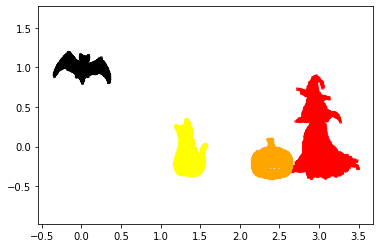

In [7]:
# ## TRAIN halloween ish. Concatenated OT maps only.
f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
f2 = ImageDataset('frames/cat2.png',noise_std=0); 
f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

n_inner = 10000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

ezshow(dat1, col='red')
ezshow(dat2, col='yellow')
ezshow(dat3, col='orange')
ezshow(dat4, col='black')

outfolder = "results/experiment_spook_cubic_OT/"
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));

xt_trajs_OT = st.get_cubic_OT_trajectory(keyframes, nsteps=20, n=2000)

st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
                       dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False)
st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render_tight',
                       dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False,tightBB=False)


In [ ]:
# ## TRAIN FISH234: Use OT cubic splines
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_OT_cubic/"

# xt_trajs_OT = st.get_cubic_OT_trajectory(keyframes, nsteps=20, n=2000)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='cubic_OT_render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False)
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='cubic_OT_render_tight',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False,tightBB=False)


In [ ]:
# # ## TRAIN halloween ish. Concatenated OT maps only.
# # f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# # f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# # f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# # f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# # n_inner = 10000;
# # n_sil = 10000 - n_inner;
# # dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# # dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# # dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# # dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# # ezshow(dat1, col='red')
# # ezshow(dat2, col='yellow')
# # ezshow(dat3, col='orange')
# # ezshow(dat4, col='black')

# # outfolder = "results/experiment_spook_OT/"

# # keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# # xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False)
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, keyframes=True, Nrbf = 100000, Nqvr=50, showVelocity=False,tightBB=False)


In [ ]:
# ## TRAIN halloween ish. jerk .01, polar .1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_polar/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. jerk .01, radial .1
# # f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# # f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# # f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# # f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# # n_inner = 10000;
# # n_sil = 10000 - n_inner;
# # dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# # dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# # dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# # dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# # ezshow(dat1, col='red')
# # ezshow(dat2, col='yellow')
# # ezshow(dat3, col='orange')
# # ezshow(dat4, col='black')

# # keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# # model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# # outfolder = "results/experiment_spook_radial/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # # model.load_state(outfolder + 'models/state_final.tar')

# # xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
# #                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
# #                        dpiv=600, sigma=None, knn=15, cycle=False, lw=5, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: noreg. sigma=7
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 7, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_noreg_sigma7/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: noreg. sigma=5
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_noreg_sigma5/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: jerk=.01. div 1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_div1/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: jerk=.01. rigid 2
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_rigid/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: jerk=.01. curl on trajectory .1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_curlmean_p1/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: jerk=.01. accel = 1
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_accel_1/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN halloween ish. base: jerk=.01. accel = 5
# f1 = ImageDataset('frames/witch.jpg',noise_std=0); 
# f2 = ImageDataset('frames/cat2.png',noise_std=0); 
# f3 = ImageDataset('frames/pumpkin.jpg',noise_std=0); 
# f4 = ImageDataset('frames/bat.jpg',noise_std=0); 

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.3], center = [3,.25], rotate = 0),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.5, -1], center = [1.4,0], rotate = 0),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.5, -.5], center = [2.4,-.15], rotate = 0),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.7, -.5], center = [0,1], rotate = 0),0); 

# ezshow(dat1, col='red')
# ezshow(dat2, col='yellow')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='black')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat3, dat2, dat4)).to(device));
# model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_spook_accel_5/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:

# # # ## TRAIN carcination. jerk=.01. seems to look fine. not really going for a point here. but it looks cool enough i guess.
# # f1 = ImageDataset('frames/lobster.jpg',noise_std=0,thresh=.50,binary=False); 
# # f2 = ImageDataset('frames/crab.jpg',noise_std=0); 

# # n_inner = 10000;
# # n_sil = 10000 - n_inner;
# # dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.7, -1], center = [0,0], rotate = 0),0); 
# # dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1], center = [.9,0], rotate = -np.pi/2),0); 

# # ezshow(dat1, col='red')
# # ezshow(dat2, col='blue')
# # plt.axis('equal')

# # keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# # model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# # outfolder = "results/experiment_carcinization_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')
# # xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
# #                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=False, lw=0, contrast=2, Nrbf = 100000, keyframes=False, tightBB=True)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # after running rect_base and rect_slight_div, run this to get areas.
# points = xt_trajs_1[0];
# areas = np.zeros(points.shape[2])
# for i in range(points.shape[2]):
#     chull = scipy.spatial.ConvexHull(points[:,:,i])
#     areas[i] = chull.volume
# areas1=areas

# points = xt_trajs_2[0];
# areas = np.zeros(points.shape[2])
# for i in range(points.shape[2]):
#     chull = scipy.spatial.ConvexHull(points[:,:,i])
#     areas[i] = chull.volume
# areas2=areas

# print(areas1[-1]-areas1[0]) 
# print(areas1.max()/areas1[0]) 

# print(areas2[-1]-areas2[0]) 
# print(areas2.max()/areas2[0]) 

# plt.plot(areas1/areas3[0],'r')
# plt.plot(areas2/areas3[0],'g')

# np.savetxt('results/outcache/areas1.txt', areas1)
# np.savetxt('results/outcache/areas2.txt', areas2)

In [ ]:
# # # # ## TRAIN rectangles. KE=.1, div=1
# n_inner = 10000;
# dat1 = torch.rand(n_inner,2)-.5
# dat2 = torch.rand(n_inner,2)-.5
# dat2[:,0]*=3;dat2[:,1]/=3;

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_rects_slight_div/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)
# xt_trajs_2 = xt_trajs

In [ ]:
# # # ## TRAIN rectangles. KE=.1, div=0
# # optimal transport from (1,1) square to (.33,3) rectangle should result in an area increase of 33.3% at the middle of the trajectory.
# n_inner = 10000;
# dat1 = torch.rand(n_inner,2)-.5
# dat2 = torch.rand(n_inner,2)-.5
# dat2[:,0]*=3;dat2[:,1]/=3;

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_rects_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)
# xt_trajs_1 = xt_trajs

In [ ]:
# # # ## TRAIN bars. KE=.01, rigid=10
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_more_rigid/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN bars. KE=.01, rigid=1
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_rigid/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # ## TRAIN bars. KE=.01
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000,keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [ ]:
# # horse down to horse up - jerk = .01
# im1 = ImageDataset('frames/horse1.jpg'); 
# im2 = ImageDataset('frames/horse2.jpg'); 
# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
# d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 
# dat1 = torch.cat(d1,0)
# dat2 = torch.cat(d2,0)
# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_horseup_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)

# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=2, keyframes=False, Nrbf = 100000)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=2, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


In [ ]:
# # # horse character to horse - jerk = .01
im1 = ImageDataset('frames/horse_charac.jpg'); 
im2 = ImageDataset('frames/horse.jpg'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 

dat1 = torch.cat(d1,0)
dat2 = torch.cat(d2,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_horse_base/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
model.load_state(outfolder+'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000)

xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)
st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
                       dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


In [ ]:
# # # horse character to horse - jerk = .01
# generate points
im1 = ImageDataset('frames/horse_charac.jpg'); 
im2 = ImageDataset('frames/horse.jpg'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 

dat1 = torch.cat(d1,0)
dat2 = torch.cat(d2,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_horse_base/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
model.load_state(outfolder+'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=10000)
np.savetxt(outfolder+'xt_trajs.txt', torch.cat((torch.tensor(xt_trajs[0].shape), xt_trajs[0].reshape(-1)),0))
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000)

xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=10000, ot_type=2)
np.savetxt(outfolder+'xt_trajs_OT.txt', torch.cat((torch.tensor(xt_trajs_OT[0].shape), xt_trajs_OT[0].reshape(-1)),0))
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


In [ ]:
# # BUTTERFLY->CAT->CATERPILLAR - KE = .01, radialke = .1
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_BCC_radial/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=4000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=1, contrast=3, Nrbf = 100000)

In [ ]:
# # BUTTERFLY->CAT->CATERPILLAR - base. KE = .01
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_BCC_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=4000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=1, contrast=3, Nrbf = 100000)

In [ ]:
# ## TRAIN FISH234 cycle. Jerk=.01. signedcurl=.1 curl everywhere
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_signedcurl_even/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=30, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

In [ ]:
# ## TRAIN FISH234 cycle. Jerk=.01. signedcurl=.1 average curl
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_signedcurl/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

In [ ]:
# ## TRAIN FISH234 cycle. Jerk=.01.
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

In [ ]:
# ## GENERATE CYCLIC BUTTERFLY->CAT->CATERPILLAR. enforce completely cyclic.
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [1, -1.2]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, .13]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, .13]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, .15]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# ## TRAIN CYCLIC BUTTERFLY->CAT->CATERPILLAR. .1 radial, .01 jerk
# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = len(keyframes)-1).to(device)
# outfolder = "results/experiment_BCC_cyclic/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=True, lw=.5, contrast=3, Nrbf = 100000)

In [ ]:
## TRAIN umbrella. Jerk=.01. poor temporal consistency because of discretized ot registration.
# f1 = ImageDataset('frames/birdflock_start.jpg',noise_std=0,thresh=.9,binary=False); 
# f2 = ImageDataset('frames/umbrella.jpg',noise_std=0,thresh=.9); 
# f3 = ImageDataset('frames/birdflock_end.jpg',noise_std=.1,thresh=1,binary=False); 

# # dat1 = torch.cat(f1.sample(1000, 0, scale = [1.5, -1.2], center = [-1.5, .125], rotate = 0),0); 
# # dat1 = torch.randn(1000,2); dat1[:,0]*=.5; dat1[:,1]*=.2; dat1[:,0]-=.6
# dat2 = torch.randn(1000,2); dat2[:,0]*=.2; dat2[:,1]*=.1; dat2[:,0]-=.2; dat2[:,1]+=.1
# dat1 = dat2.clone(); dat1[:,0]-=.5
# dat3 = torch.cat(f2.sample(900, 100, scale = [1, -1.1], center = [.13, -.05], rotate = 0),0); 
# dat4 = torch.cat(f3.sample(1000, 0, scale = [2, -2], center = [.2, .2], rotate = 0),0); 
# dat5 = torch.randn(1000,2); dat5[:,0]*=.8; dat5[:,1]*=.8; dat5[:,1]+=.5

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='orange')
# ezshow(dat3, col='red')
# ezshow(dat4, col='blue')
# # ezshow(dat5, col='green')

# # keyframes = torch.stack((dat1, dat2, dat3, dat4, dat5)).to(device);
# keyframes = torch.stack((dat1, dat2, dat3, dat4)).to(device);

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_umbrella_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True, lr = 1e-4, scaling = .4, normalize=False)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=100)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_points',
#                        dpiv=600, sigma=.01, knn=1, cycle=False, lw=.01, contrast=1, Nrbf = 0, keyframes=False, showVelocity=False, plotKeypoints=True)

In [ ]:
## TRAIN MF. Jerk=.01, div=1, rig.1
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.11, .125], rotate = 0),0); 
dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.13, -.05], rotate = -np.pi*.375),0); 
dat3 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, -.2], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='blue')

keyframes = torch.stack((dat1, dat2, dat3)).to(device);

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MMF_rigdiv/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=False)
# model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

In [ ]:
## TRAIN MF. Jerk=.01, 
# f1 = ImageDataset('frames/male.jpg',noise_std=0); 
# f2 = ImageDataset('frames/female.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.2, .5], rotate = -np.pi/7),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_MF2_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

In [ ]:
# ## TRAIN MF. Jerk=.01
# f1 = ImageDataset('frames/male.jpg',noise_std=0); 
# f2 = ImageDataset('frames/female.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.11, .325], rotate = 0),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.13, .15], rotate = -np.pi*.375),0); 
# dat3 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat3, col='blue')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_MMF_base/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

In [ ]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.2, -1], center = [-.07, .9], rotate = -np.pi/2),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.9, 0], rotate = -np.pi),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.9], rotate = np.pi/2),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.9, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

In [ ]:
## TRAIN FISH1234 circle. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [ ]:
## TRAIN FISH1234 circle. Jerk=.01. rigid=.1, curl-pi=.1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
model.load_state(outfolder + 'models/state_0050.tar')
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=953, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 5e-5, scaling = .4)

In [ ]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
# model.load_state(outfolder + 'models/state_final.tar')
model.load_state(outfolder + 'models/state_0050.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True, lw=2)

In [ ]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF2_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
## GENERATE MF IMAGES
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

In [ ]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
## TRAIN MF. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, .6], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, -.6], rotate = 0),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, .6], rotate = 0),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, -.6], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

In [ ]:
## TRAIN FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
# RENDER FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [ ]:
## TRAIN FISH1234. Jerk=.01, curl=1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_mincurl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
## TRAIN FISH1234. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [ ]:
# RENDER FISH1234
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [ ]:
## GENERATE BUNCH OF IMAGES
im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')